In [1]:
import os
current_dir = %pwd
project_dir = os.path.dirname(current_dir)
%cd $project_dir

c:\Users\Bryan Fernandez\Desktop\doc-classifier


C:\Users\Bryan Fernandez\AppData\Roaming\Python\Python310\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# LIBRAIRIES ET FONCTIONS

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from src import create_inference_dataset, create_test_dataset, image_read
import pandas as pd
from src import image_grid_sample, plot_image
import re
from sklearn import metrics
import seaborn as sns
from pathlib import Path



def display_layers(model):
    # Get the names of all layers
    layer_names = [layer.name for layer in model.layers]

    # Print the layer names
    for name in layer_names:
        print(name)


def compute_gradcam(img, model, class_idx):
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = model(img)
        loss = predictions[:, class_idx]

    # Gradient of the loss with respect to the convolutional layer output
    grads = tape.gradient(loss, conv_outputs)

    # Compute the guided gradients
    guided_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the convolutional layer output with the computed gradients
    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[None, None, :]
    weighted_conv_outputs = conv_outputs * guided_grads

    # Compute the Grad-CAM heatmap
    cam = np.mean(weighted_conv_outputs, axis=-1)

    # Normalize the heatmap
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    return cam


def grad_cam(img: np.array, layer_name: str, saved_model, base_model=None):
    
    # Load and preprocess the image
    dataset = create_inference_dataset(img, batch_size=1)
    # Directly get the image as a numpy array
    preprocessed_img = next(iter(dataset)).numpy()

    # Determine whether to use base_model or saved_model
    model_to_use = base_model if isinstance(
        base_model, tf.keras.Model) else saved_model

    # The target layer (typically the last convolutional layer)
    layer = model_to_use.get_layer(layer_name)

    # Create a Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=model_to_use.inputs,
        outputs=[layer.output, model_to_use.output]
    )

    # Predict the class of the input image using saved_model
    preds = saved_model.predict(preprocessed_img)
    class_idx = np.argmax(preds[0])

    # Compute Grad-CAM
    cam = compute_gradcam(preprocessed_img, grad_model, class_idx)

    # Overlay Grad-CAM on the image
    original_img = img
    heatmap = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    return original_img, superimposed_img


def prediction_csv(model,test_dataset,X_test,Y_test,cat_dict,match):

    Y_pred = model.predict(test_dataset)
    conf_matrix = pd.DataFrame(
        metrics.confusion_matrix(Y_test, Y_pred.argmax(axis=1)))

    # Step 1: Get the predicted class labels
    Y_pred_labels = Y_pred.argmax(axis=1)

    # Step 2: Identify mismatches
    mismatches = Y_test != Y_pred_labels

    # Step 3: Filter wrong predictions
    wrong_predictions = X_test[mismatches]
    # Convert to DataFrame if not already
    wrong_predictions = pd.DataFrame(wrong_predictions)

    # Step 4: Add real and predicted classes to the DataFrame
    wrong_predictions['Classe réelle'] = Y_test[mismatches]
    wrong_predictions['Classe prédite'] = Y_pred_labels[mismatches]
    wrong_predictions = wrong_predictions.replace(
        cat_dict.values(), list(cat_dict.keys()))
    wrong_predictions = wrong_predictions.rename({0: "image_path"}, axis=1)

    conf_matrix.to_csv(
        f"references\{match.group(1)}\confusion_matrix_{match.group(1)}", index=False)
    wrong_predictions.to_csv(
        f"references\{match.group(1)}\wrong_predictions_{match.group(1)}",index= False)
    
    return conf_matrix,wrong_predictions

# CREATION JEU D'ECHANTILLON

In [3]:
df_test = pd.read_csv(r'data\processed\DL_test.csv')

cat_dict = {
    "Email": 0,
    "Handwritten": 1,
    "Invoice": 2,
    "ID Card": 3,
    "Passeport": 4,
    "Scientific publication": 5
}
categories = list(cat_dict.keys())

In [4]:
X_test = df_test['image_path'].values
Y_test = df_test['category'].values
test_dataset = create_test_dataset(X_test, Y_test)

In [5]:
df_sample = pd.DataFrame()
for i in df_test["category"].unique():
    df_to_concat = df_test[df_test['category'] == i].sample(n=8, random_state=1)
    df_sample = pd.concat([df_sample, df_to_concat], ignore_index=True)

In [6]:
df_sample = df_sample.replace(cat_dict.values(), categories)

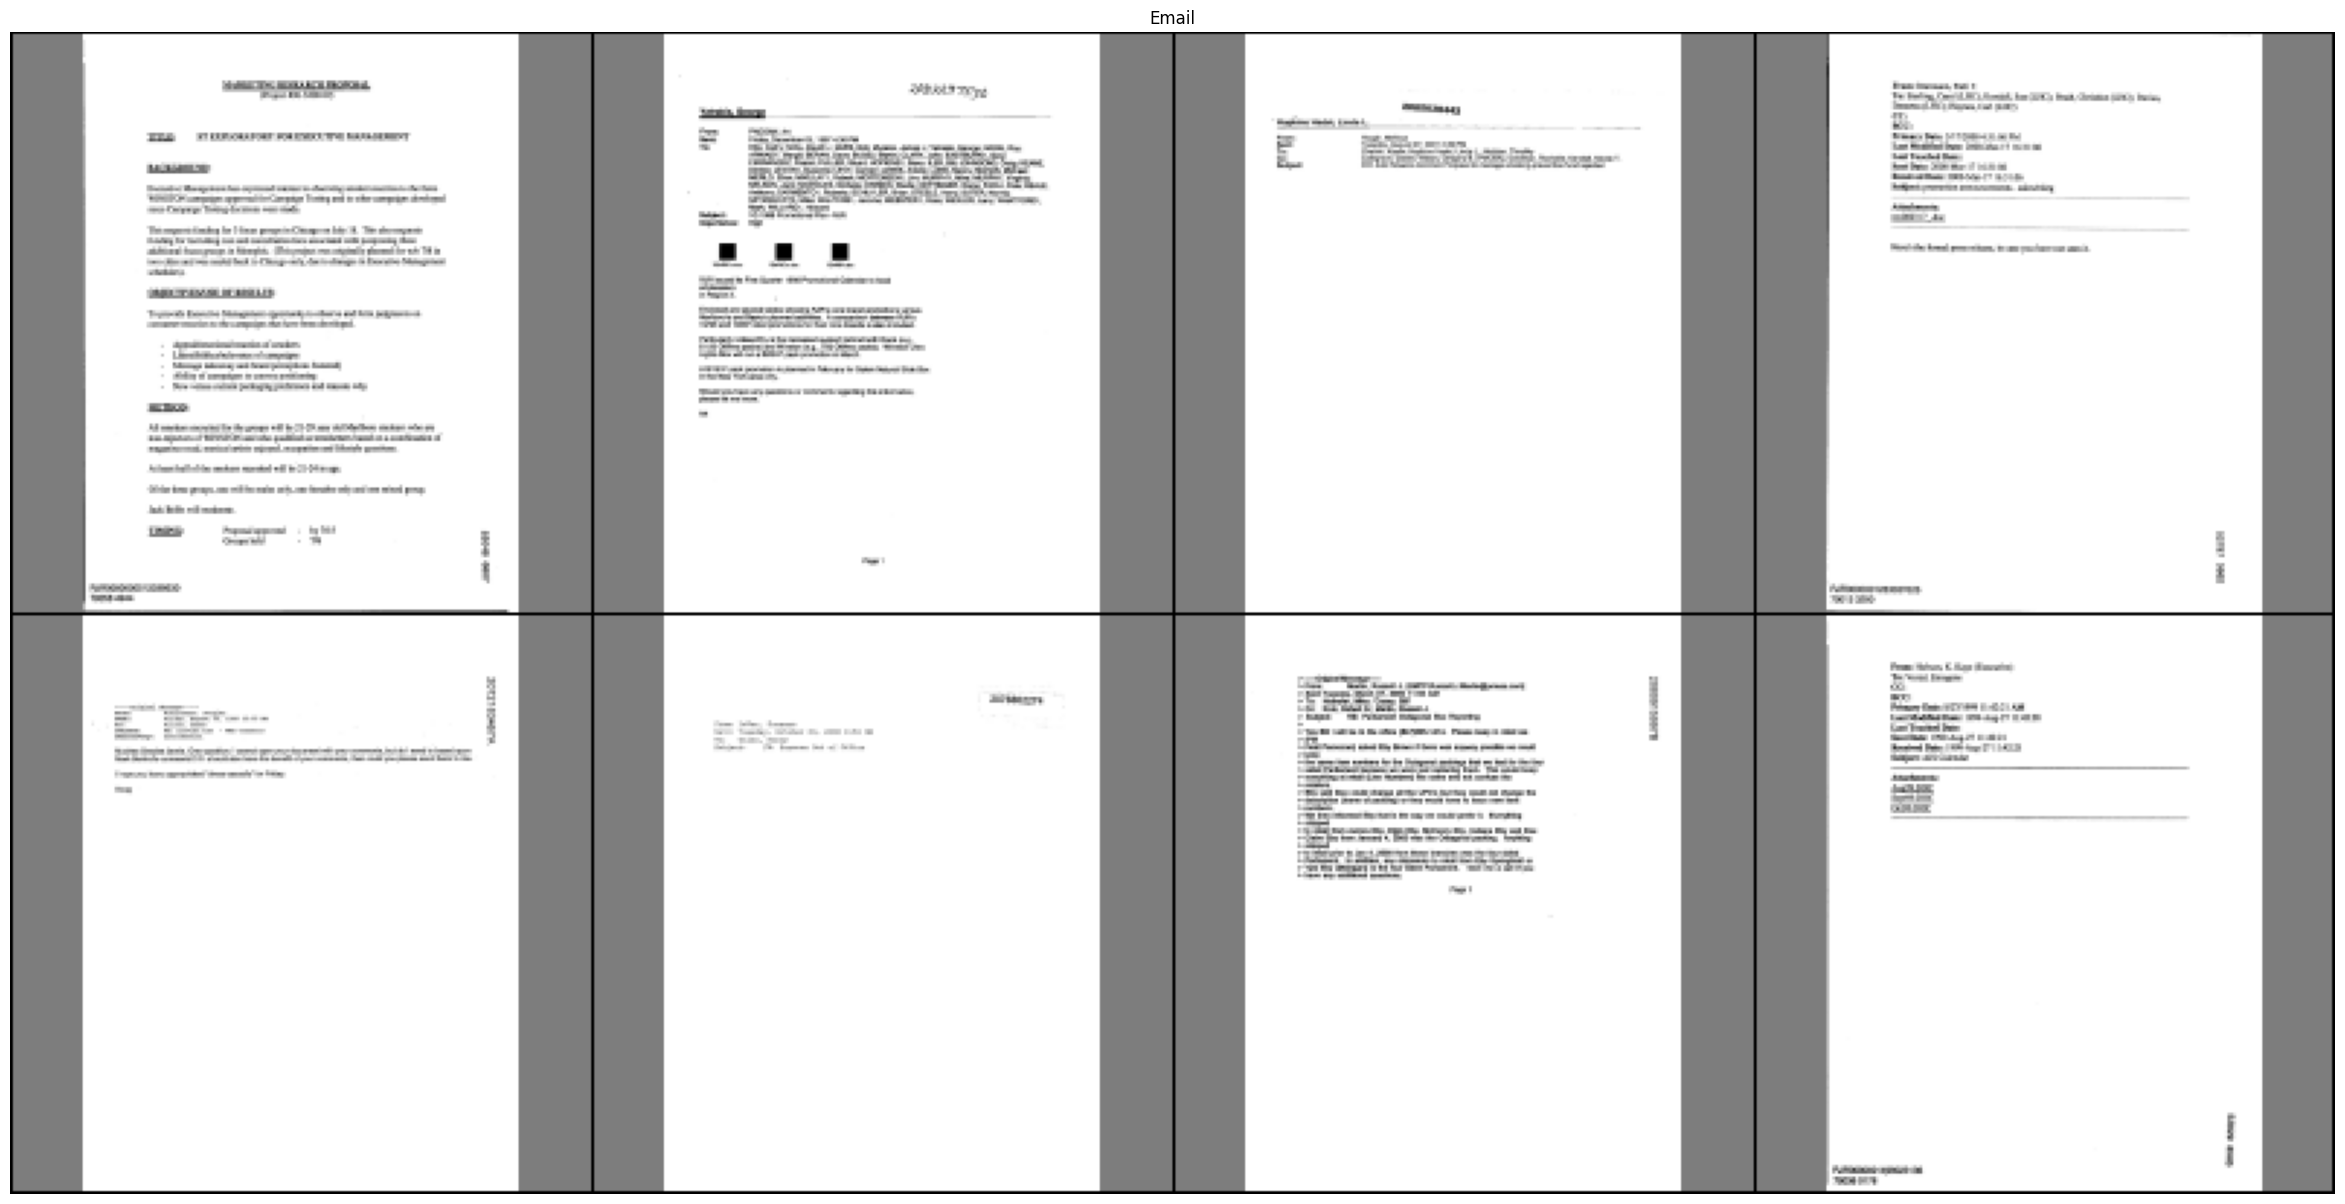

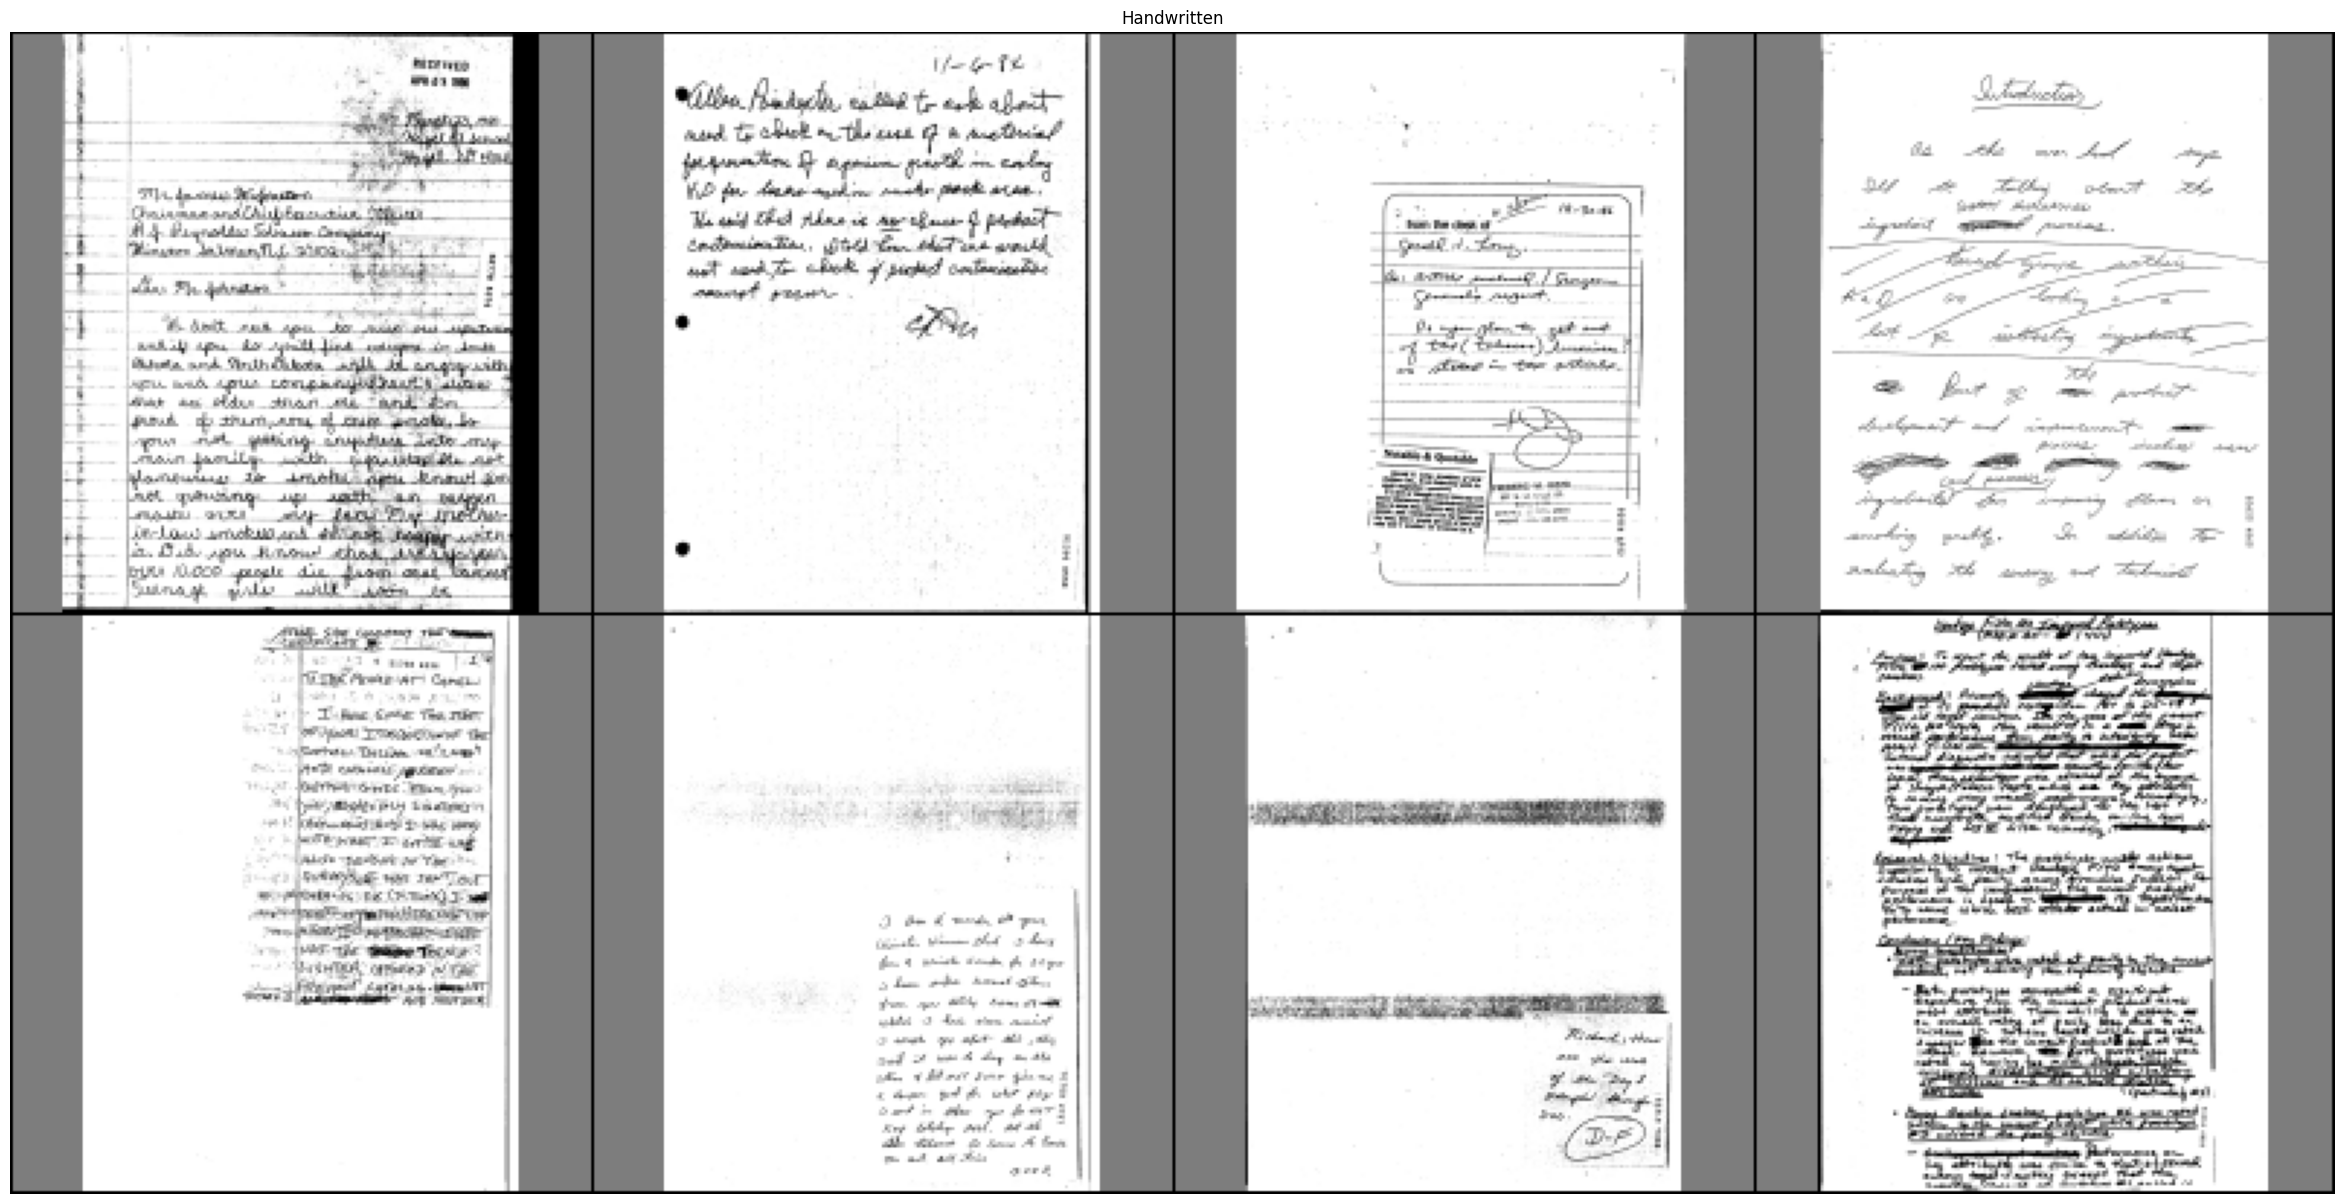

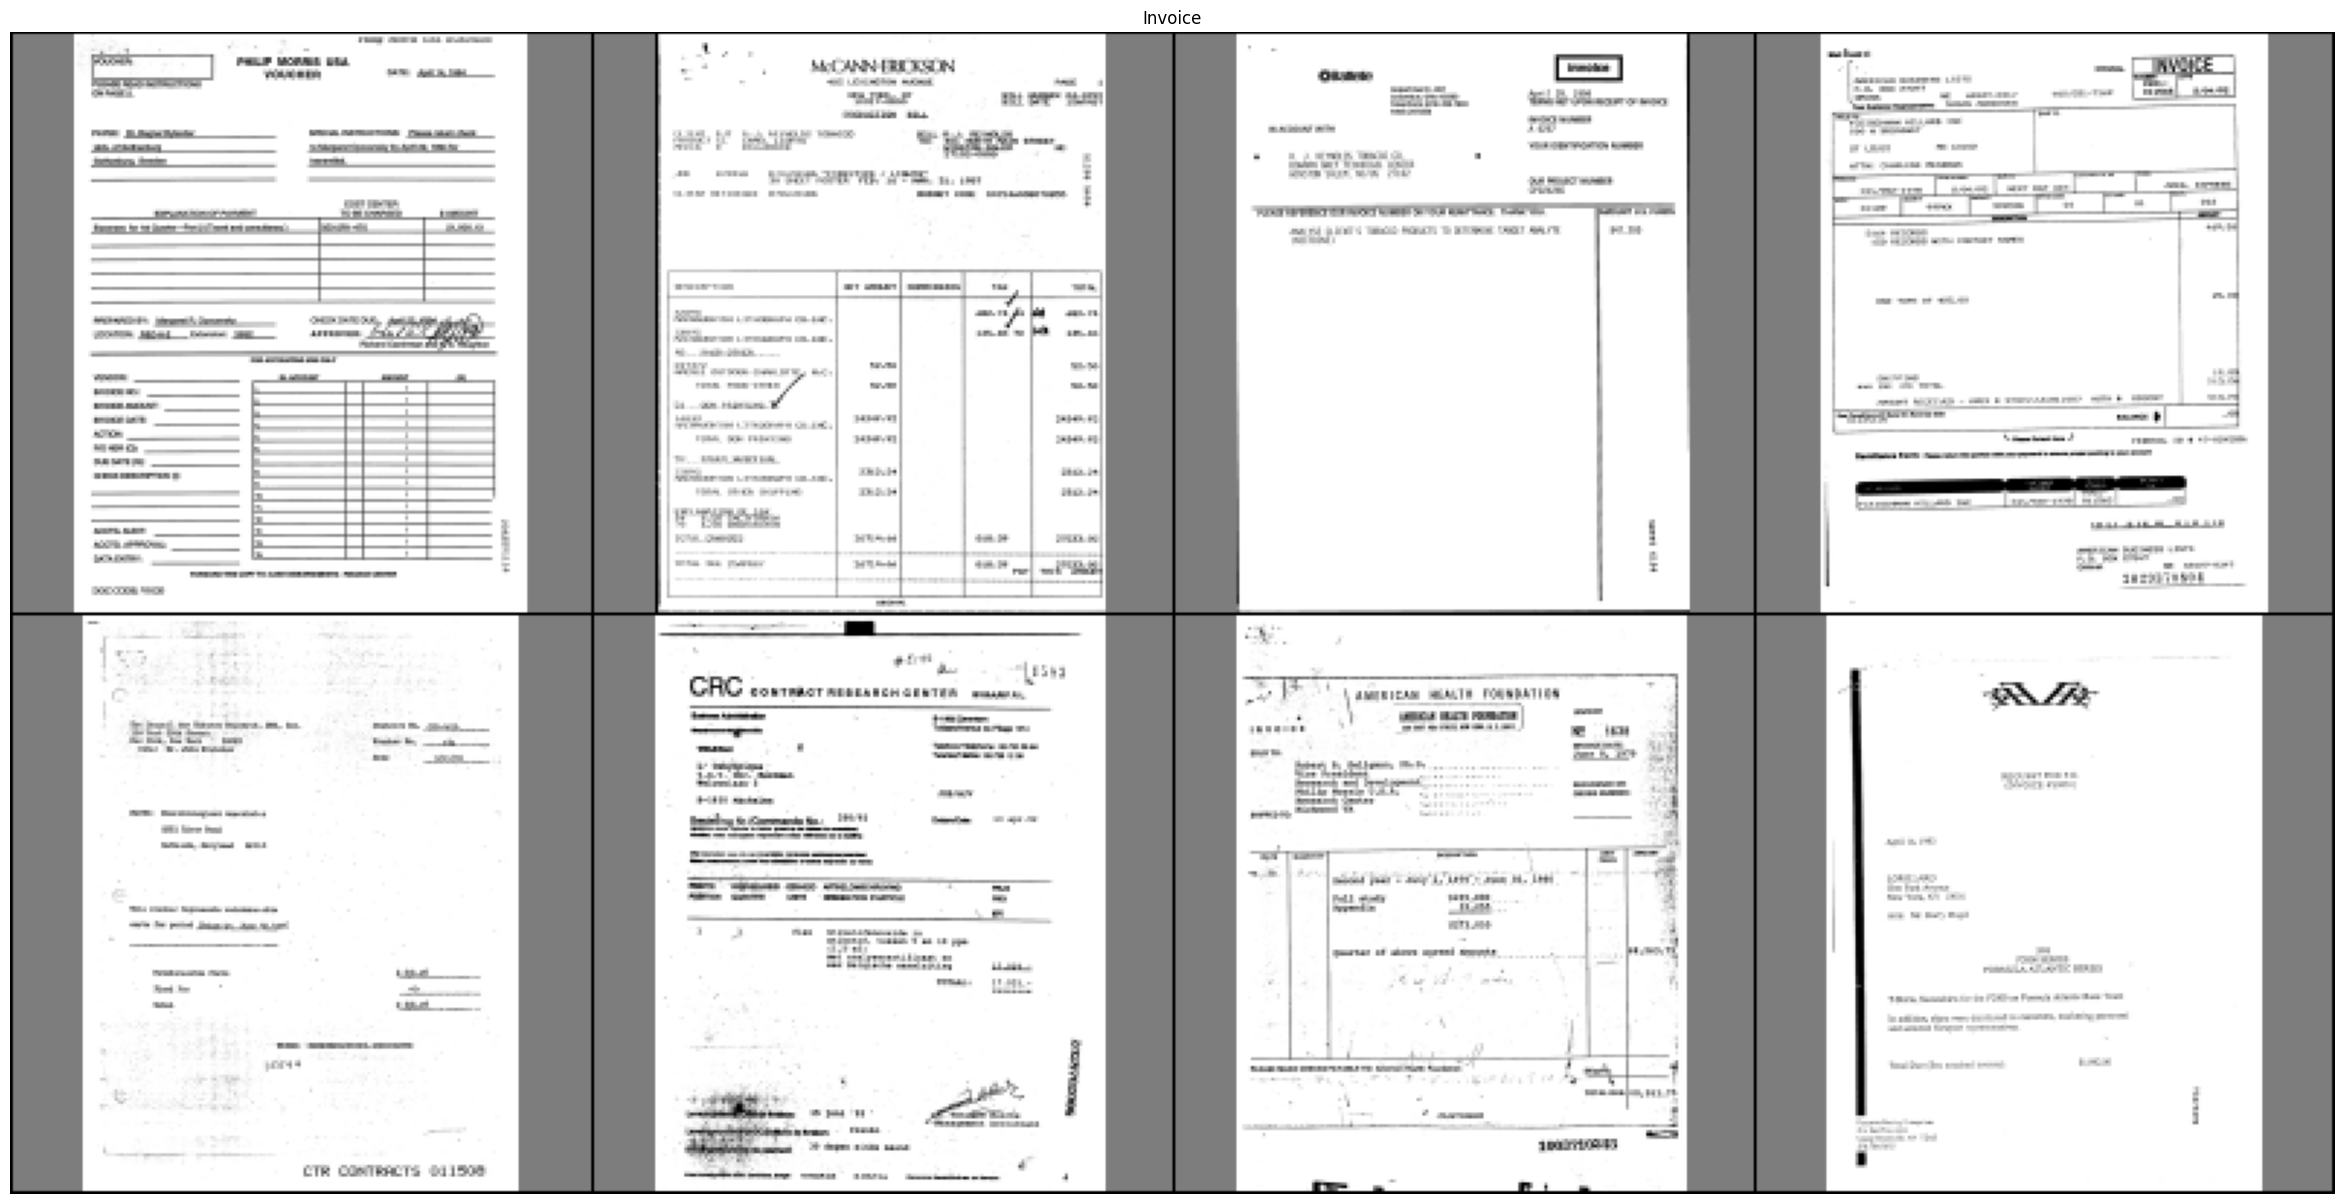

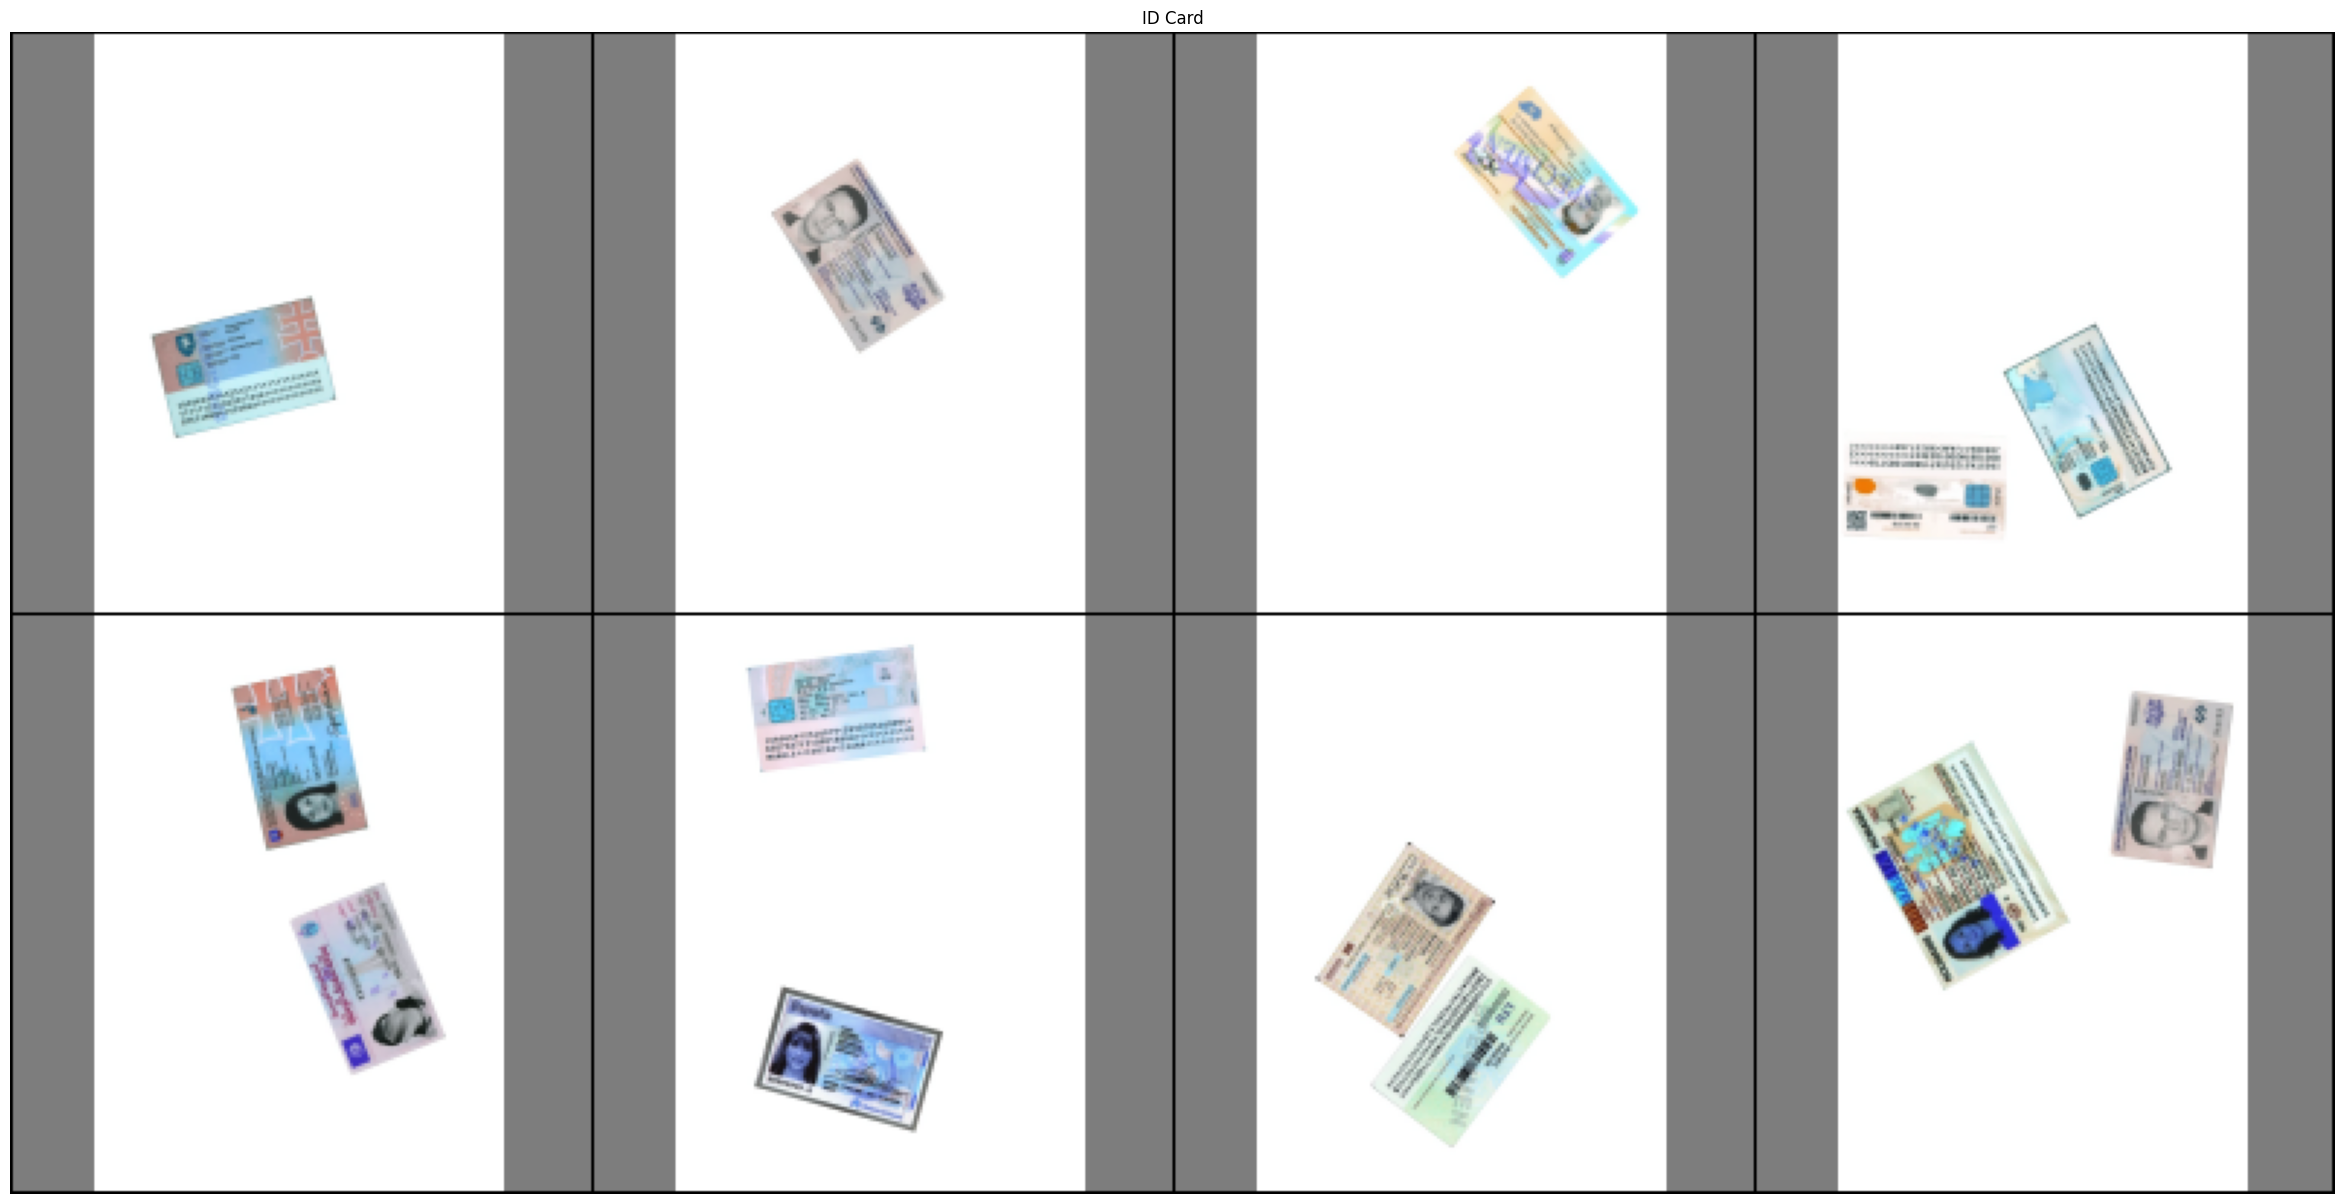

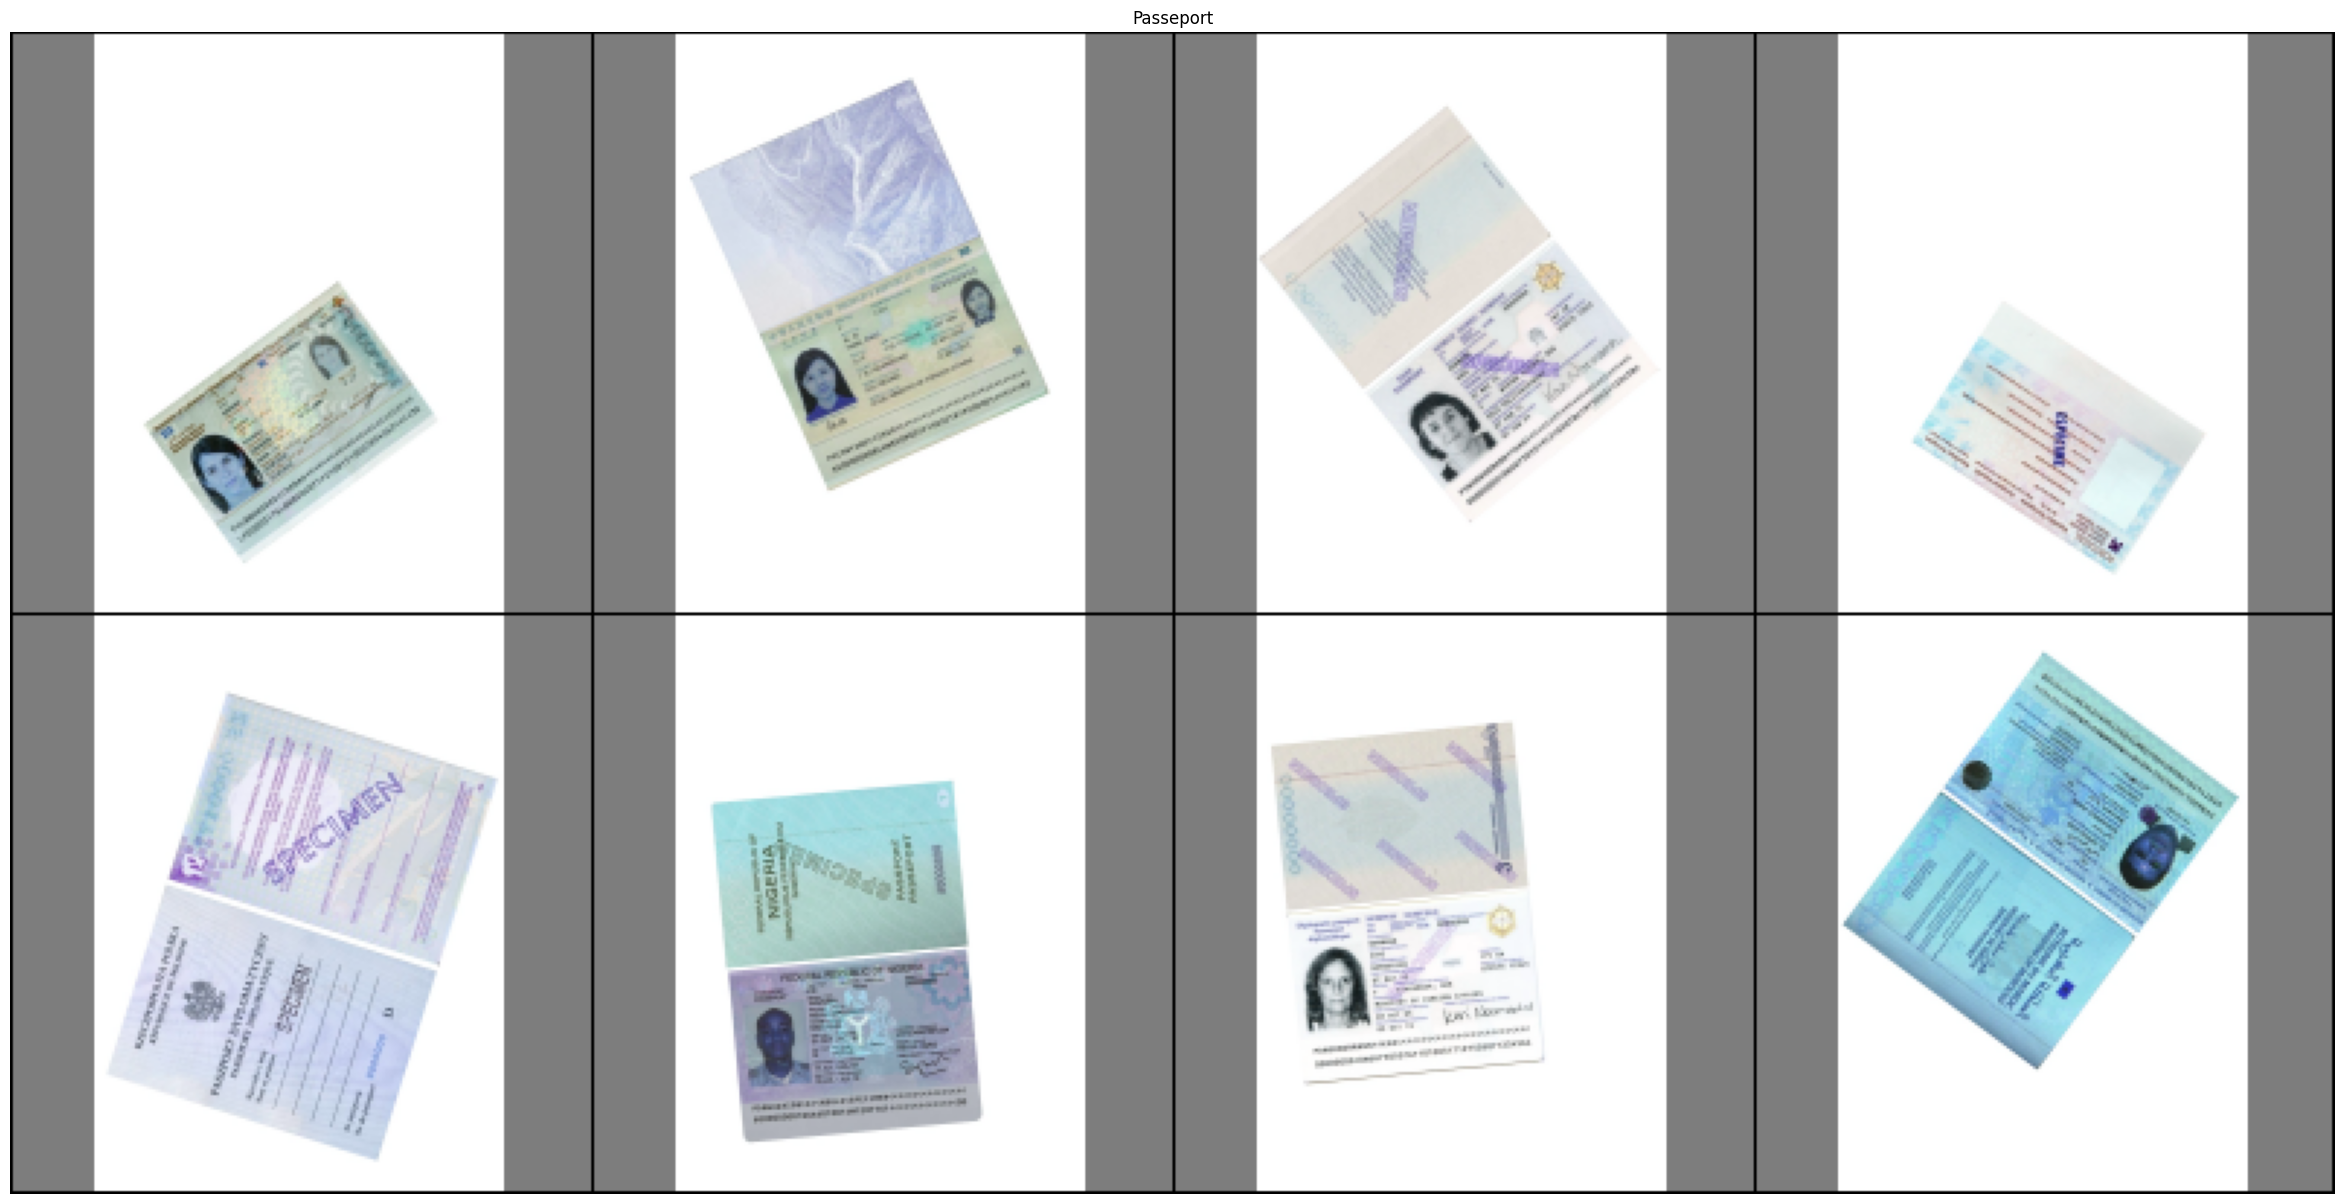

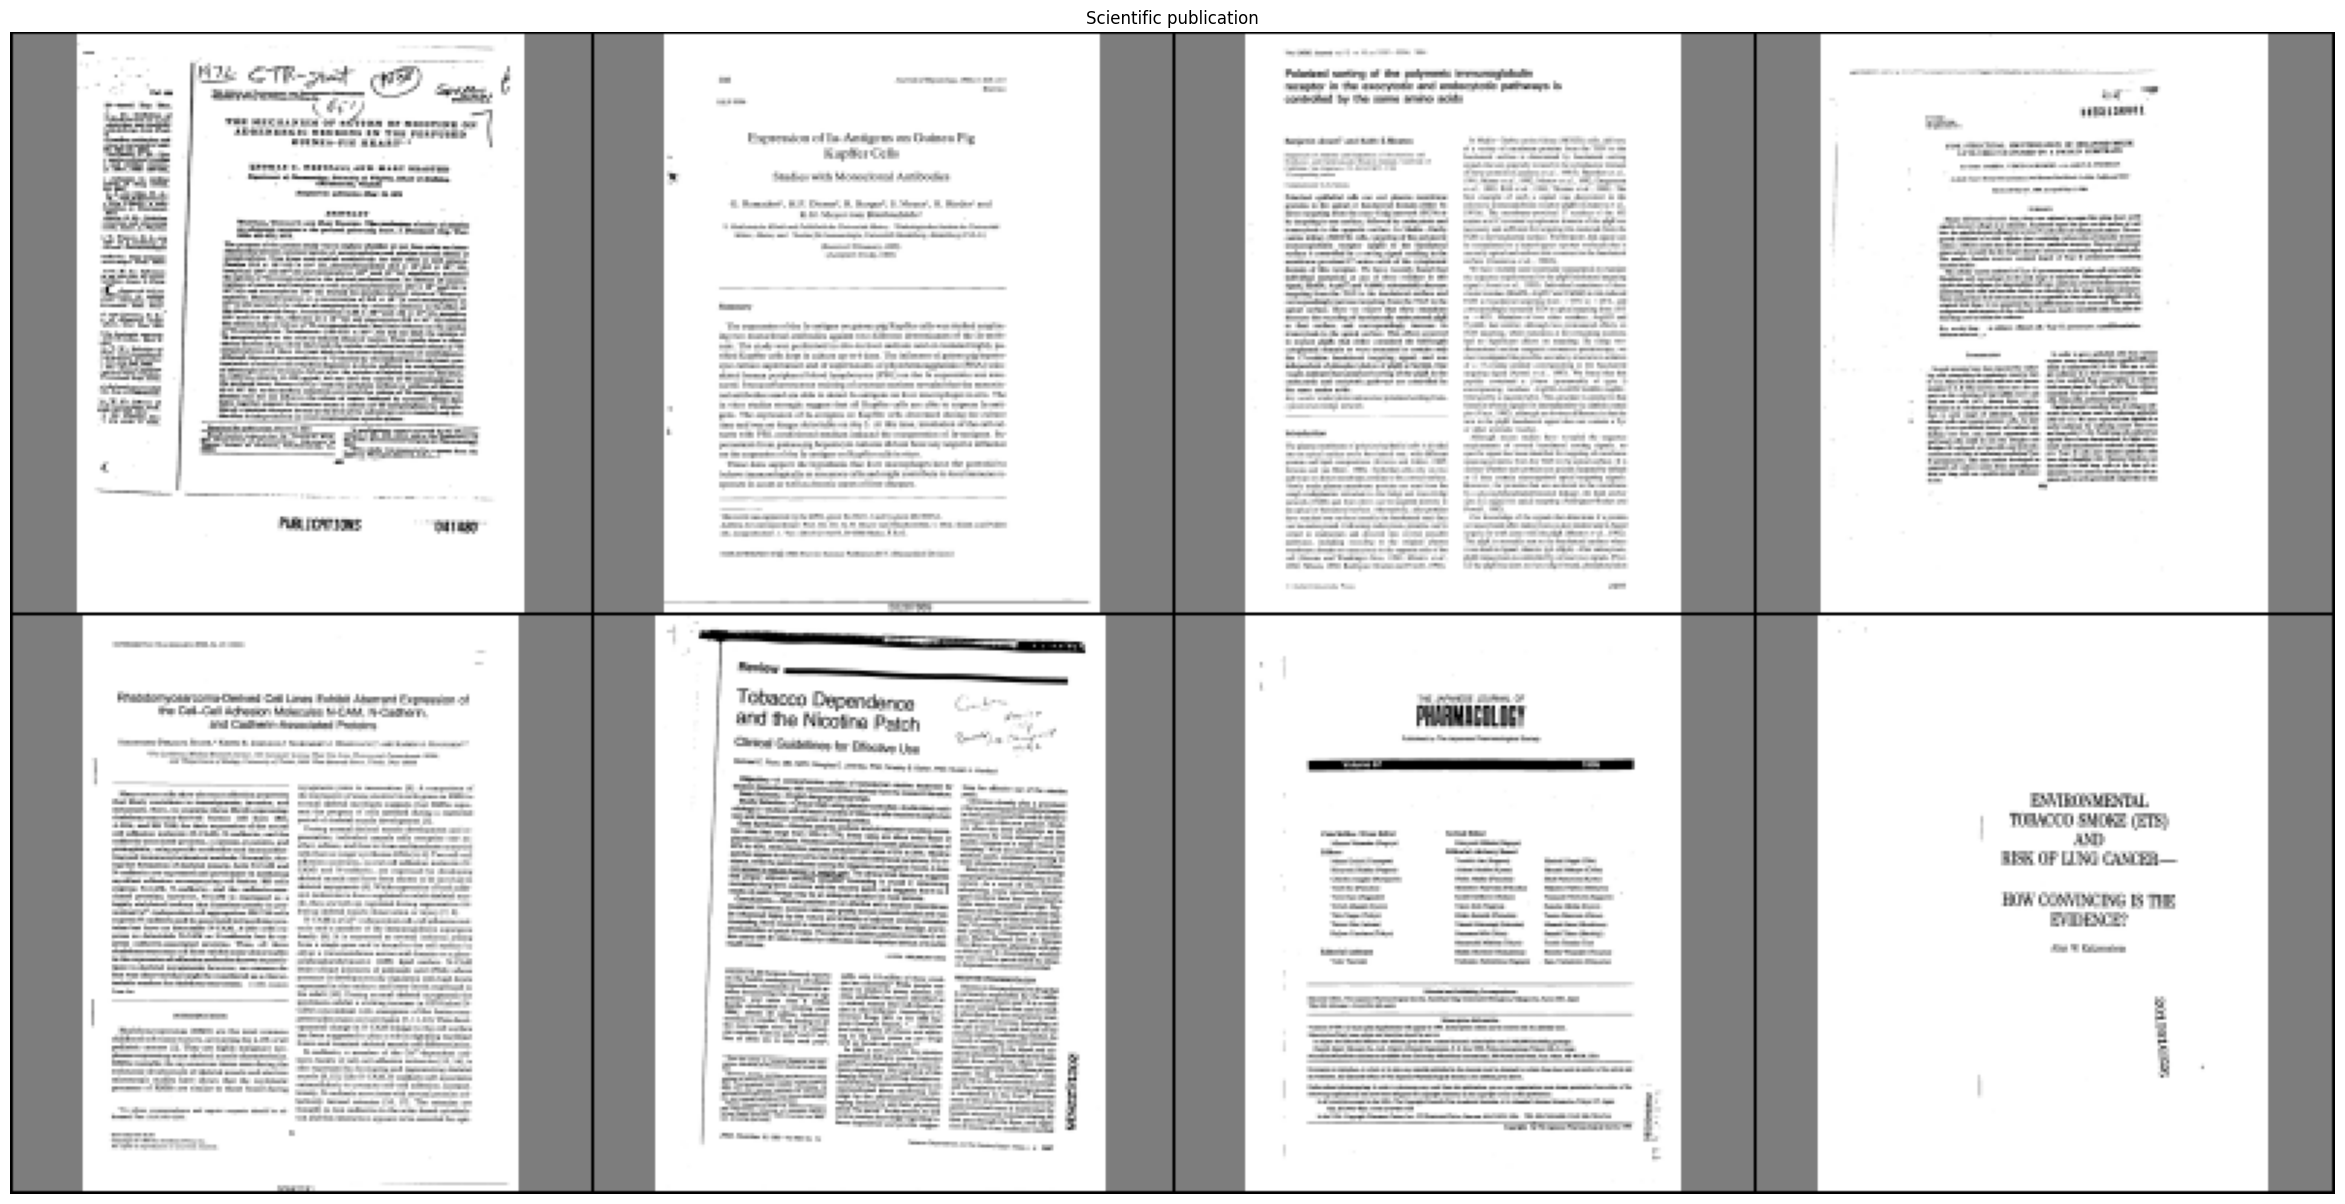

In [7]:
for i in categories:
    originals = []
    for j in df_sample["image_path"][df_sample["category"]==i]:
        img = image_read(j)
        originals.append(img)
    image_grid_originals = image_grid_sample(
            originals, 2, 4, square_size=200, img_layout='center', seed=42)
    plot_image(image_grid_originals, (30, 30),i, flip_image_layers=False)

# CNN

In [8]:
model_path = r'models\CNN_ckpt_best_loss.keras'
model = tf.keras.models.load_model(model_path)

# Regular expression to extract "CNN"
pattern = r'\\([A-Za-z0-9_]+)_ckpt'

# Search for the pattern in the string
match = re.search(pattern, model_path)

# Create folder for model in reference folder
result_folder = fr"references\{match.group(1)}"
folder = Path(result_folder)
if not folder.exists():
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Folder created: {result_folder}")

# Display layers
display_layers(model)

conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dropout
dense_1


In [9]:
conf_matrix, wrong_predictions = prediction_csv(model, test_dataset,X_test,Y_test,cat_dict,match)

54/54 [==============================] - 10s 132ms/step


In [10]:
for i in categories:
    subset = wrong_predictions[wrong_predictions["Classe réelle"] == i]
    
    for j in categories:
        originals = []
        sub_subset = subset["image_path"][subset["Classe prédite"]==j]

        if len(sub_subset) > 0:  # Proceed only if the subset is not empty
            n_samples = min(8, len(sub_subset))
            for k in sub_subset.sample(n=n_samples, random_state=1):
                originals.append(image_read(k))
                
            image_grid_originals = image_grid_sample(
                originals, 2, 4, square_size=200, img_layout='center', seed=42)

            #plot_image(image_grid_originals, (30, 30),
            #           f'Modèle : {match.group(1)}\nClasse réelle: {i}\nClasse prédite: {j}', flip_image_layers=False)
            
            cv2.imwrite(fr"{result_folder}\wrong_{match.group(1)}_reelle_{i}_pred_{j}.jpg", image_grid_originals)

In [11]:
for i in categories:
    originals = []
    heatmaps = []
    for j in df_sample["image_path"][df_sample["category"] == i]:
        img = image_read(j)
        a, b = grad_cam(img, 'conv2d_2', model)
        originals.append(a)
        heatmaps.append(b)
        
    # Create grids
    image_grid_originals = image_grid_sample(
        originals, 2, 4, square_size=200, img_layout='center', seed=42)
    image_grid_heatmap = image_grid_sample(
        heatmaps, 2, 4, square_size=200, img_layout='center', seed=42)
    
    # Plot original grid and heatmap grid
    """plot_image(image_grid_originals, (30, 30),
               f'Echantillon originale\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)

    plot_image(image_grid_heatmap, (30, 30),
               f'Echantillon Grad-CAM\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)"""
    
    # Save images
    image_grid_heatmap = cv2.cvtColor(image_grid_heatmap, cv2.COLOR_RGB2BGR)
    cv2.imwrite(
        fr"{result_folder}\originals_{match.group(1)}_{i}.jpg", image_grid_originals)
    cv2.imwrite(
        fr"{result_folder}\heatmaps_{match.group(1)}_{i}.jpg", image_grid_heatmap)

1/1 [==============================] - 0s 1ms/step


C:\conda_temp\ipykernel_12180\2309388766.py:46: RuntimeWarning: invalid value encountered in divide
  cam = cam / cam.max()
C:\conda_temp\ipykernel_12180\2309388766.py:81: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


1/1 [==============================] - 0s 17ms/step


# SqueezeNet

In [12]:
model_path = r'models\SqueezeNet_ckpt_best_loss.keras'
model = tf.keras.models.load_model(model_path)

# Regular expression to extract "CNN"
pattern = r'\\([A-Za-z0-9_]+)_ckpt'

# Search for the pattern in the string
match = re.search(pattern, model_path)

# Create folder for model in reference folder
result_folder = fr"references\{match.group(1)}"
folder = Path(result_folder)
if not folder.exists():
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Folder created: {result_folder}")

# Display layers
display_layers(model)

input_1
conv2d
max_pooling2d
conv2d_1
conv2d_2
conv2d_3
concatenate
conv2d_4
conv2d_5
conv2d_6
concatenate_1
conv2d_7
conv2d_8
conv2d_9
concatenate_2
max_pooling2d_1
conv2d_10
conv2d_11
conv2d_12
concatenate_3
conv2d_13
conv2d_14
conv2d_15
concatenate_4
conv2d_16
conv2d_17
conv2d_18
concatenate_5
conv2d_19
conv2d_20
conv2d_21
concatenate_6
max_pooling2d_2
conv2d_22
conv2d_23
conv2d_24
concatenate_7
dropout
conv2d_25
global_average_pooling2d
activation


In [13]:
conf_matrix, wrong_predictions = prediction_csv(model, test_dataset, X_test,Y_test,cat_dict,match)

54/54 [==============================] - 10s 167ms/step


In [14]:
for i in categories:
    subset = wrong_predictions[wrong_predictions["Classe réelle"] == i]

    for j in categories:
        originals = []
        sub_subset = subset["image_path"][subset["Classe prédite"] == j]

        if len(sub_subset) > 0:  # Proceed only if the subset is not empty
            n_samples = min(8, len(sub_subset))
            for k in sub_subset.sample(n=n_samples, random_state=1):
                originals.append(image_read(k))

            image_grid_originals = image_grid_sample(
                originals, 2, 4, square_size=200, img_layout='center', seed=42)

            # plot_image(image_grid_originals, (30, 30),
            #           f'Modèle : {match.group(1)}\nClasse réelle: {i}\nClasse prédite: {j}', flip_image_layers=False)

            cv2.imwrite(
                fr"{result_folder}\wrong_{match.group(1)}_reelle_{i}_pred_{j}.jpg", image_grid_originals)

In [15]:
for i in categories:
    originals = []
    heatmaps = []
    for j in df_sample["image_path"][df_sample["category"] == i]:
        img = image_read(j)
        a, b = grad_cam(img, 'conv2d_25', model)
        originals.append(a)
        heatmaps.append(b)

    # Create grids
    image_grid_originals = image_grid_sample(
        originals, 2, 4, square_size=200, img_layout='center', seed=42)
    image_grid_heatmap = image_grid_sample(
        heatmaps, 2, 4, square_size=200, img_layout='center', seed=42)

    # Plot original grid and heatmap grid
    """plot_image(image_grid_originals, (30, 30),
               f'Echantillon originale\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)

    plot_image(image_grid_heatmap, (30, 30),
               f'Echantillon Grad-CAM\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)"""

    # Save images
    image_grid_heatmap = cv2.cvtColor(image_grid_heatmap, cv2.COLOR_RGB2BGR)
    cv2.imwrite(
        fr"{result_folder}\originals_{match.group(1)}_{i}.jpg", image_grid_originals)
    cv2.imwrite(
        fr"{result_folder}\heatmaps_{match.group(1)}_{i}.jpg", image_grid_heatmap)

1/1 [==============================] - 0s 17ms/step


# MobileNetV2

In [16]:
# Load model
model_path = r'models\MobileNetV2_ckpt_best_loss.keras'
model = tf.keras.models.load_model(model_path)

# Regular expression to extract "CNN"
pattern = r'\\([A-Za-z0-9_]+)_ckpt'

# Search for the pattern in the string
match = re.search(pattern, model_path)

# Create folder for model in reference folder
result_folder = fr"references\{match.group(1)}"
folder = Path(result_folder)
if not folder.exists():
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Folder created: {result_folder}")

# Display layers
display_layers(model)

Folder created: references\MobileNetV2
input_1
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
bl

In [17]:
conf_matrix, wrong_predictions = prediction_csv(model, test_dataset, X_test, Y_test,cat_dict,match)

54/54 [==============================] - 11s 172ms/step


In [18]:
for i in categories:
    subset = wrong_predictions[wrong_predictions["Classe réelle"] == i]

    for j in categories:
        originals = []
        sub_subset = subset["image_path"][subset["Classe prédite"] == j]

        if len(sub_subset) > 0:  # Proceed only if the subset is not empty
            n_samples = min(8, len(sub_subset))
            for k in sub_subset.sample(n=n_samples, random_state=1):
                originals.append(image_read(k))

            image_grid_originals = image_grid_sample(
                originals, 2, 4, square_size=200, img_layout='center', seed=42)

            # plot_image(image_grid_originals, (30, 30),
            #           f'Modèle : {match.group(1)}\nClasse réelle: {i}\nClasse prédite: {j}', flip_image_layers=False)

            cv2.imwrite(
                fr"{result_folder}\wrong_{match.group(1)}_reelle_{i}_pred_{j}.jpg", image_grid_originals)

In [19]:
for i in categories:
    originals = []
    heatmaps = []
    for j in df_sample["image_path"][df_sample["category"] == i]:
        img = image_read(j)
        a, b = grad_cam(img, 'Conv_1_bn', model)
        originals.append(a)
        heatmaps.append(b)

    # Create grids
    image_grid_originals = image_grid_sample(
        originals, 2, 4, square_size=200, img_layout='center', seed=42)
    image_grid_heatmap = image_grid_sample(
        heatmaps, 2, 4, square_size=200, img_layout='center', seed=42)

    # Plot original grid and heatmap grid
    """plot_image(image_grid_originals, (30, 30),
               f'Echantillon originale\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)

    plot_image(image_grid_heatmap, (30, 30),
               f'Echantillon Grad-CAM\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)"""

    # Save images
    image_grid_heatmap = cv2.cvtColor(image_grid_heatmap, cv2.COLOR_RGB2BGR)
    cv2.imwrite(
        fr"{result_folder}\originals_{match.group(1)}_{i}.jpg", image_grid_originals)
    cv2.imwrite(
        fr"{result_folder}\heatmaps_{match.group(1)}_{i}.jpg", image_grid_heatmap)

1/1 [==============================] - 0s 18ms/step


# EfficientNetB1

In [20]:
# Load model
model_path = r'models\EfficientNetB1_ckpt_best_loss.keras'
saved_model = tf.keras.models.load_model(model_path)

# Regular expression to extract "CNN"
pattern = r'\\([A-Za-z0-9_]+)_ckpt'

# Search for the pattern in the string
match = re.search(pattern, model_path)

# Create folder for model in reference folder
result_folder = fr"references\{match.group(1)}"
folder = Path(result_folder)
if not folder.exists():
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Folder created: {result_folder}")

# Display layers
display_layers(saved_model)

Folder created: references\EfficientNetB1
efficientnetb1
global_average_pooling2d
dense
dense_1


In [21]:
conf_matrix, wrong_predictions = prediction_csv(model, test_dataset, X_test, Y_test, cat_dict,match)

54/54 [==============================] - 9s 166ms/step


In [22]:
for i in categories:
    subset = wrong_predictions[wrong_predictions["Classe réelle"] == i]

    for j in categories:
        originals = []
        sub_subset = subset["image_path"][subset["Classe prédite"] == j]

        if len(sub_subset) > 0:  # Proceed only if the subset is not empty
            n_samples = min(8, len(sub_subset))
            for k in sub_subset.sample(n=n_samples, random_state=1):
                originals.append(image_read(k))

            image_grid_originals = image_grid_sample(
                originals, 2, 4, square_size=200, img_layout='center', seed=42)

            # plot_image(image_grid_originals, (30, 30),
            #           f'Modèle : {match.group(1)}\nClasse réelle: {i}\nClasse prédite: {j}', flip_image_layers=False)

            cv2.imwrite(
                fr"{result_folder}\wrong_{match.group(1)}_reelle_{i}_pred_{j}.jpg", image_grid_originals)

In [23]:
# Get the base model
base_model = saved_model.get_layer("efficientnetb1")

# Get the names of all layers
display_layers(base_model)

input_1
rescaling
normalization
tf.math.truediv
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add

In [24]:
for i in categories:
    originals = []
    heatmaps = []
    for j in df_sample["image_path"][df_sample["category"] == i]:
        img = image_read(j)
        a, b = grad_cam(img, 'top_conv', saved_model, base_model)
        originals.append(a)
        heatmaps.append(b)

    # Create grids
    image_grid_originals = image_grid_sample(
        originals, 2, 4, square_size=200, img_layout='center', seed=42)
    image_grid_heatmap = image_grid_sample(
        heatmaps, 2, 4, square_size=200, img_layout='center', seed=42)

    # Plot original grid and heatmap grid
    """plot_image(image_grid_originals, (30, 30),
               f'Echantillon originale\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)

    plot_image(image_grid_heatmap, (30, 30),
               f'Echantillon Grad-CAM\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)"""

    # Save images
    image_grid_heatmap = cv2.cvtColor(image_grid_heatmap, cv2.COLOR_RGB2BGR)
    cv2.imwrite(
        fr"{result_folder}\originals_{match.group(1)}_{i}.jpg", image_grid_originals)
    cv2.imwrite(
        fr"{result_folder}\heatmaps_{match.group(1)}_{i}.jpg", image_grid_heatmap)

1/1 [==============================] - 0s 28ms/step


# ResNet50

In [25]:
# Load model
model_path = r'models\ResNet50_ckpt_best_loss.keras'
saved_model = tf.keras.models.load_model(model_path)

# Regular expression to extract "CNN"
pattern = r'\\([A-Za-z0-9_]+)_ckpt'

# Search for the pattern in the string
match = re.search(pattern, model_path)

# Create folder for model in reference folder
result_folder = fr"references\{match.group(1)}"
folder = Path(result_folder)
if not folder.exists():
    folder.mkdir(parents=True, exist_ok=True)
    print(f"Folder created: {result_folder}")

# Display layers
display_layers(saved_model)

Folder created: references\ResNet50
resnet50
global_average_pooling2d
dense
dense_1


In [26]:
conf_matrix, wrong_predictions = prediction_csv(model, test_dataset, X_test, Y_test, cat_dict, match)

54/54 [==============================] - 11s 190ms/step


In [27]:
for i in categories:
    subset = wrong_predictions[wrong_predictions["Classe réelle"] == i]

    for j in categories:
        originals = []
        sub_subset = subset["image_path"][subset["Classe prédite"] == j]

        if len(sub_subset) > 0:  # Proceed only if the subset is not empty
            n_samples = min(8, len(sub_subset))
            for k in sub_subset.sample(n=n_samples, random_state=1):
                originals.append(image_read(k))

            image_grid_originals = image_grid_sample(
                originals, 2, 4, square_size=200, img_layout='center', seed=42)

            # plot_image(image_grid_originals, (30, 30),
            #           f'Modèle : {match.group(1)}\nClasse réelle: {i}\nClasse prédite: {j}', flip_image_layers=False)

            cv2.imwrite(
                fr"{result_folder}\wrong_{match.group(1)}_reelle_{i}_pred_{j}.jpg", image_grid_originals)

In [28]:
# Get the base model
base_model = saved_model.get_layer("resnet50")

# Get the names of all layers
display_layers(base_model)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [29]:
for i in categories:
    originals = []
    heatmaps = []
    for j in df_sample["image_path"][df_sample["category"] == i]:
        img = image_read(j)
        a, b = grad_cam(img, 'conv5_block3_out', saved_model, base_model)
        originals.append(a)
        heatmaps.append(b)

    # Create grids
    image_grid_originals = image_grid_sample(
        originals, 2, 4, square_size=200, img_layout='center', seed=42)
    image_grid_heatmap = image_grid_sample(
        heatmaps, 2, 4, square_size=200, img_layout='center', seed=42)

    # Plot original grid and heatmap grid
    """plot_image(image_grid_originals, (30, 30),
               f'Echantillon originale\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)

    plot_image(image_grid_heatmap, (30, 30),
               f'Echantillon Grad-CAM\nModèle : {match.group(1)}\nCategorie: {i}', flip_image_layers=False)"""

    # Save images
    image_grid_heatmap = cv2.cvtColor(image_grid_heatmap, cv2.COLOR_RGB2BGR)
    cv2.imwrite(
        fr"{result_folder}\originals_{match.group(1)}_{i}.jpg", image_grid_originals)
    cv2.imwrite(
        fr"{result_folder}\heatmaps_{match.group(1)}_{i}.jpg", image_grid_heatmap)

1/1 [==============================] - 0s 21ms/step
